# Cross Entropy Method on FrozenLake and CliffWalking



In [ ]:
!pip install gym

In [ ]:
!git clone https://github.com/henritomas/cs295-rl

# Cross-Entropy Method
Unlike SARSA and Q-learning, CEM uses a neural network (spec. MLP) to model the policy function $\pi(a|s)$ . 

The input to an MLP is a 1D tensor; since we want the observed state as the input, we must categorically encode each state (called a One-Hot encoding) by wrapping the .observation() method of the gym environment and editing it to return states as one-hot vectors.

In [ ]:
%cd /content/cs295-rl
!git pull

In [3]:
import sys
import os
if "./" not in sys.path:
  sys.path.append("./") 

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import itertools
from collections import defaultdict
from lib import plotting
from tqdm import tqdm

matplotlib.style.use('ggplot')

In the following section, an observation wrapper is used to alter the returned states to one-hot vectors.


In [4]:
class OneHotEncoding(gym.ObservationWrapper):

    def __init__(self, env):
        super(OneHotEncoding, self).__init__(env)
        n_states = env.observation_space.n
        self.observation_space = gym.spaces.Box(0.0, 1.0, (n_states, ), dtype=np.float32)

    def observation(self, state):
        reward = np.copy(self.observation_space.low)
        reward[state] = 1.0
        return reward

env = OneHotEncoding(gym.make('FrozenLake-v0', is_slippery=False))

# Show the one-hot vector initial state:
s = env.reset()
print(s)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Neural Network

We create the neural network to model the policy. NNs are empirically built (lots of trial and error with what architectures and hyperparameters work) so we arbitrarily design an MLP with 1 hidden layer with 128 neurons / hidden units. 

### Input

The input to the neural network is the observed state `s`, as a one-hot vector; 

### Output

its output is a probability mass function for the possible actions `[p_up, p_down, p_left, p_right]`. 



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyNN(nn.Module):

    def __init__(self, n_states, n_actions):
        super(PolicyNN, self).__init__()

        self.hidden = nn.Linear(n_states, 128)
        self.output = nn.Linear(128, n_actions)

    def forward(self, x):

        x = F.relu(self.hidden(x))
        x = self.output(x)

        return x
    
    def predict(self, x):

        x = self.forward(x)
        
        return F.softmax(x, dim=0)

### Policy wrapper

We wrap the neural network around an action-selection function that selects the next action based on the NN's output PMF. 

In [6]:
def policy(net, state):

    with torch.no_grad():

        inputs = torch.tensor(state).cuda()
        preds = net.predict(inputs)
        preds = preds.cpu().numpy()

    # preds is the NN's predicted probability of taking an action.
    # The policy is to follow this distribution choosing actions.
    action = np.random.choice(len(preds), p=preds)

    return action

## Training

The neural network policy is trained with state-action pairs from **Elite, Successful Episodes**, as training on episodes where the agent failed is counter intuitive. 
___
### Step-by-step


1. Run episode loops until a sufficient or specified amount of episodes is reached.
2. Select episodes with better rewards / state-actions that the model can learn from. This is usually a percentage containing the best episodes, e.g. 'the top 30% episodes'
3. Train the neural network on predicting the correct action given a state, using the top 30% state-actions as data.
4. Repeat until a target mean reward is reached.
___
### Elite episode priority


To prioritize 'more successful episodes', the episodes where the agent has least actions in reaching the goal is picked (length of episode). We represent this as the discounted reward 

(`episode_length` $- 6$)$^{\gamma} * r$

where r can be [1.0, 0.0] based on if the agent reached the goal. In this way, if the agent reaches the goal in 6 actions it gets perfect reward 1.0, but if it takes longer the reward gets reduced. 
___
### Tunable Hyperparameters
- **lr**: Learning rate $\epsilon$ for updating the neural network's weights.
- **elite_ratio**: Ratio of top episodes to use for training the policy network.
- **n_episodes**: Number of episodes to run with current policy before sampling the top episodes.
- **n_epochs**: Number of training epochs or loops for updating the policy neural network. 


In [8]:
def cem_frozenlake(env, lr=1e-3, elite_ratio=0.3, n_episodes=100, n_epochs=1):

    net = PolicyNN(n_states=4*4, n_actions=4)
    net.cuda()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=net.parameters(), lr=lr)

    batch_size = int(elite_ratio * n_episodes)

    stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(n_epochs*n_episodes),
    episode_rewards=np.zeros(n_epochs*n_episodes))

    for epoch in tqdm(range(n_epochs)):

        # Dataset
        all_states = []
        all_actions = []
        mean_ep_reward = []
        all_rewards = []

        for episode in range(n_episodes):

            # Store states and actions of this episode in:
            ep_states = []
            ep_actions = []
            ep_reward = 0
            total_r = 0.
            
            # Reset, get initial state
            s = env.reset()

            for t in itertools.count():

                a = policy(net, s)
                s_prime, r, done, _ = env.step(a)

                # Frozenlake: Save state-action-rewards for CEM
                ep_states.append(s)
                ep_actions.append(a)
                if done and r > 0:
                    ep_reward = 0.9**(len(ep_states))
                    # 6 actions to perfectly solve FrozenLake

                total_r += r
                if done:
                    break

                s = s_prime

            # Update stats
            stats.episode_lengths[epoch*n_episodes + episode] = t
            stats.episode_rewards[epoch*n_episodes + episode] = total_r
            
            # Append this episode to dataset
            all_states.extend(ep_states)
            all_actions.extend(ep_actions)
            all_rewards.extend([ep_reward] * (len(ep_states))) # each state is assigned the episode's reward.
            mean_ep_reward.append(ep_reward)

        #print('Epoch {} mean reward: {:.5f}'.format(
        #    epoch, np.mean(np.array(mean_ep_reward))))

        all_states, all_actions, all_rewards = map(
            np.array, [all_states, all_actions, all_rewards])

        best_episodes = np.argsort(-all_rewards)[:batch_size]

        x_states = all_states[best_episodes]
        y_actions = all_actions[best_episodes]

        # Training the neural network
        x_states, y_actions = map(torch.from_numpy, [x_states, y_actions])
        x_states, y_actions = map(lambda x: x.cuda(), [x_states, y_actions])

        preds = net(x_states)
        loss = loss_fn(preds, y_actions)
        loss.backward()
        optimizer.step()

    return stats

## CEM on Deterministic FrozenLake

100%|██████████| 200/200 [00:36<00:00,  5.55it/s]


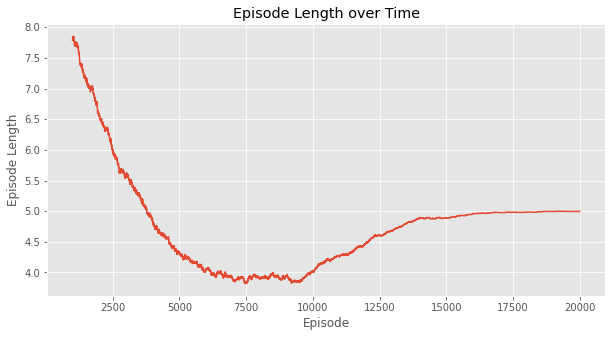

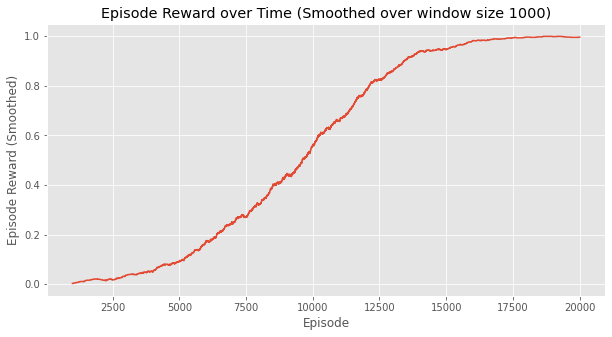

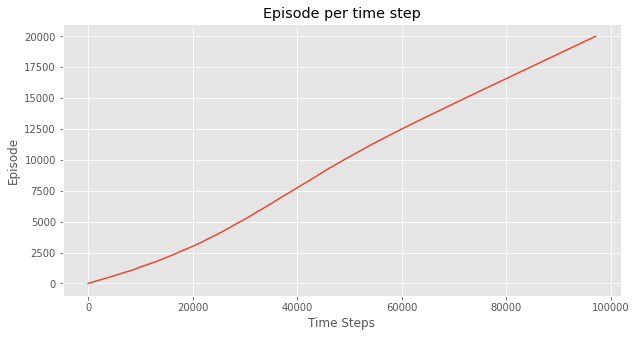

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
stats = cem_frozenlake(env, n_epochs=200)
plotting.plot_episode_stats(stats, smoothing_window=1000)

## CEM on Stochastic FrozenLake-v0

In contrast to CEM's performance on Deterministic FrozenLake-v0, it performs very poorly given the current reward function and elite episode selection. This is due to CEM being more of a supervised method of learning; since a model has a significant % of slipping even when it takes the right action, updating the neural network weights based on mislabeled data proves to be difficult. 

100%|██████████| 200/200 [00:39<00:00,  5.13it/s]


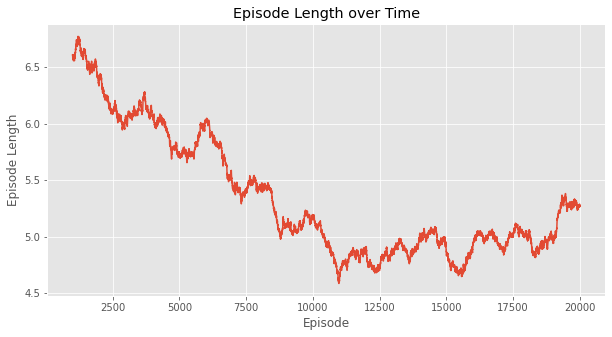

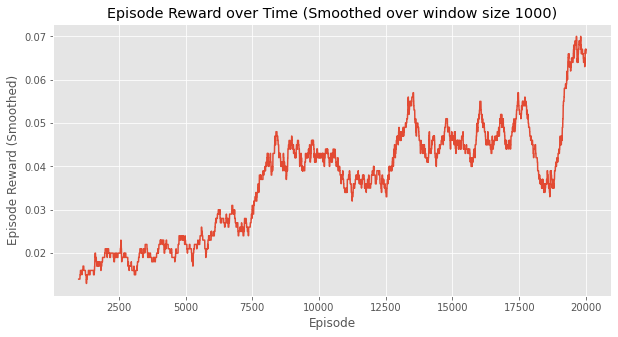

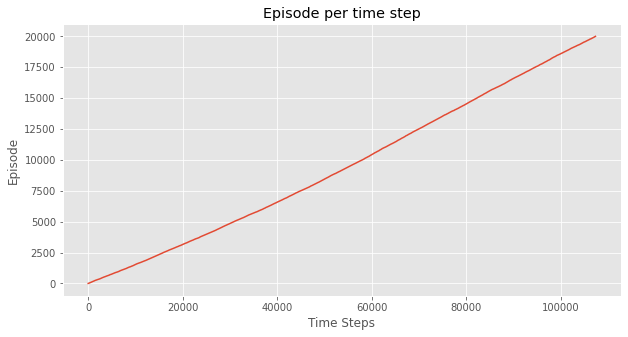

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
env = OneHotEncoding(gym.make('FrozenLake-v0', is_slippery=True))
stats = cem_frozenlake(env, n_epochs=200)
plotting.plot_episode_stats(stats, smoothing_window=1000)

## Cliff Walking Environment

To adjust CEM for the cliff walking environment, we adjust the input and output layers of the PolicyNN to accomodate the 4*12 states due to the different gridsize compared to frozenlake. The results are similar to performance on deterministic frozenlake, reaching a reward of -13 (perfect amount of moves towards the goal). 

In [7]:
def cem_cliffwalking(env, lr=1e-3, elite_ratio=0.3, n_episodes=100, n_epochs=1):

    net = PolicyNN(n_states=4*12, n_actions=4)
    net.cuda()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=net.parameters(), lr=lr)

    batch_size = int(elite_ratio * n_episodes)

    stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(n_epochs*n_episodes),
    episode_rewards=np.zeros(n_epochs*n_episodes))

    for epoch in tqdm(range(n_epochs)):

        # Dataset
        all_states = []
        all_actions = []
        mean_ep_reward = []
        all_rewards = []

        for episode in range(n_episodes):

            # Store states and actions of this episode in:
            ep_states = []
            ep_actions = []
            ep_reward = 0
            total_r = 0.
            
            # Reset, get initial state
            env.reset()
            s = env.get_state_onehot()

            for t in itertools.count():

                a = policy(net, s)
                s_prime, r, done, _ = env.step(a)
                s_prime = env.get_state_onehot()

                # Frozenlake: Save state-action-rewards for CEM
                ep_states.append(s)
                ep_actions.append(a)
                if done and r == -1:
                    ep_reward = 0.9**(len(ep_states))

                total_r += r
                if done:
                    break

                s = s_prime

            # Update stats
            stats.episode_lengths[epoch*n_episodes + episode] = t
            stats.episode_rewards[epoch*n_episodes + episode] = total_r
            
            # Append this episode to dataset
            all_states.extend(ep_states)
            all_actions.extend(ep_actions)
            all_rewards.extend([ep_reward] * (len(ep_states))) # each state is assigned the episode's reward.
            mean_ep_reward.append(ep_reward)

        #print('Epoch {} mean reward: {:.5f}'.format(
        #    epoch, np.mean(np.array(mean_ep_reward))))

        all_states, all_actions, all_rewards = map(
            np.array, [all_states, all_actions, all_rewards])

        best_episodes = np.argsort(-all_rewards)[:batch_size]

        x_states = all_states[best_episodes]
        y_actions = all_actions[best_episodes]

        # Training the neural network
        x_states, y_actions = map(torch.from_numpy, [x_states, y_actions])
        x_states, y_actions = map(lambda x: x.cuda(), [x_states, y_actions])

        preds = net(x_states)
        loss = loss_fn(preds, y_actions)
        loss.backward()
        optimizer.step()

    return stats

100%|██████████| 250/250 [02:49<00:00,  1.47it/s]


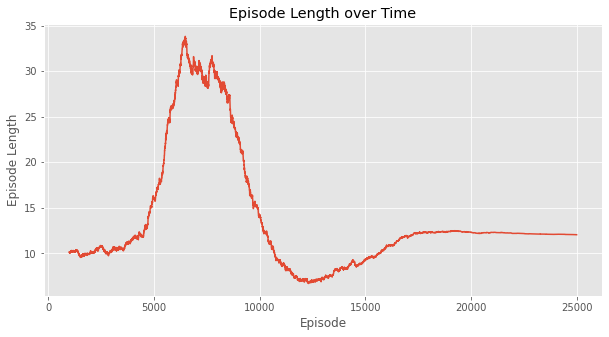

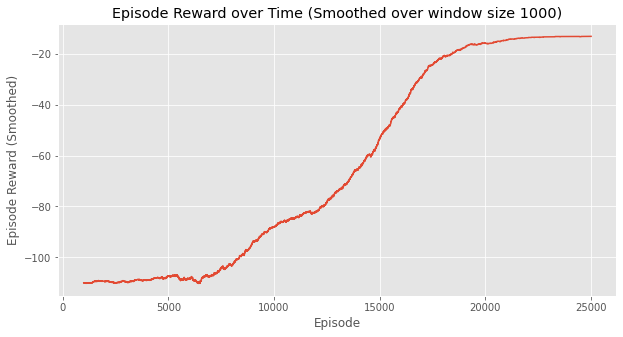

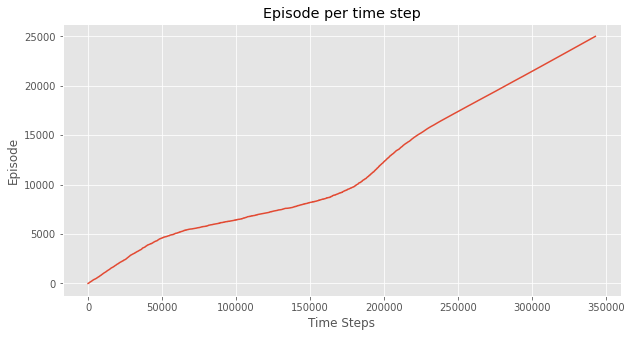

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [9]:
from lib.envs import CliffWalkingEnv

env = CliffWalkingEnv(4,12)

stats = cem_cliffwalking(env, n_epochs=250)
plotting.plot_episode_stats(stats, smoothing_window=1000)